In [1]:
!pip install -U -q tensorflow tensorflow_datasets
#!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 42.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 82.5 MB/s eta 0:00:00


Import the necessary packages

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from numpy import random
import shutil

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

Download the speech commands dataset

In [3]:
DATASET_PATH = 'data/'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'speech_commands.zip',
      origin='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
      extract=True,
      cache_dir='.', cache_subdir='data')

2428923189/2428923189 [==============================] - 46s 0us/step


Get different class labels

In [4]:
commands = np.array(tf.io.gfile.listdir(str('data')))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['.DS_Store' 'marvin' 'bed' 'on' 'five' 'LICENSE' 'testing_list.txt' 'wow'
 'house' 'right' 'up' 'down' 'left' 'yes' 'happy' 'nine' 'off' 'dog'
 'stop' 'speech_commands.zip' 'zero' 'forward' 'backward' 'tree' 'four'
 'go' 'visual' 'two' 'seven' 'bird' '_background_noise_' 'sheila' 'learn'
 'follow' 'no' 'cat' 'six' 'validation_list.txt' 'eight' 'three' 'one']


Form the director yfor string on, off, others and silent data

In [5]:
os.mkdir('data/mydataset')

In [6]:
!cp -r 'data/on' 'data/mydataset'
!cp -r 'data/off' 'data/mydataset'

In [7]:
os.mkdir('data/mydataset/silent')
os.mkdir('data/mydataset/others')

In [8]:
other_labels = ["yes", "no", "up", "down", "left", "right","bed", "bird", "cat", "dog", "happy", "house", "marvin", "sheila", "tree", "wow"]
sample_per_label = 150


for label in other_labels:
  path = 'data/'+label

  f = os.listdir(path)
  num_files = len(f)
  file_indx = np.arange(num_files)
  random.shuffle(file_indx)
  for i in range(sample_per_label):
    index = file_indx[i]
    file_name = f[index]
    source = path + '/' + file_name
    destination = 'data/mydataset/others/' + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)

Create silent data

In [9]:
import scipy
from scipy.io.wavfile import write

fs = 16000
num_files = 2400

for i in range(num_files):
  sample = np.zeros(fs)
  filename = str(i*100)+'silent.wav'
  sample = sample + 0.1*random.randn(fs)
  scipy.io.wavfile.write('data/mydataset/silent/'+filename, fs, sample.astype(np.int16))

Split the data into training and validation set

In [10]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='data/mydataset',
    labels='inferred',
    batch_size=64,
    class_names=None,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print('label names:', label_names)

Found 11967 files belonging to 4 classes.
Using 9574 files for training.
Using 2393 files for validation.

label names: ['off' 'on' 'others' 'silent']


Remove the exytra audio channel

In [11]:
train_ds.element_spec

def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)


In [12]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [13]:
for sample_audio, sample_label in train_ds.take(1):  
  print(sample_audio.shape)
  print(sample_label.shape)

(64, 16000)
(64,)


Function to compute audio spectrogram

In [14]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=127, frame_step=64)
  # Obtain the absolute magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a third dimension as channel, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Audio playback

In [15]:
from IPython import display

for i in range(5):
  indx = random.randint(0, sample_audio.shape[0]-1)
  label = label_names[sample_label[indx]]
  waveform = sample_audio[indx]
  #spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Audio shape:', waveform.shape)
  #print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: off
Audio shape: (16000,)
Audio playback


Label: off
Audio shape: (16000,)
Audio playback


Label: off
Audio shape: (16000,)
Audio playback


Label: others
Audio shape: (16000,)
Audio playback


Label: on
Audio shape: (16000,)
Audio playback


Plot spectrogram function

In [16]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

ploting the spectrogram

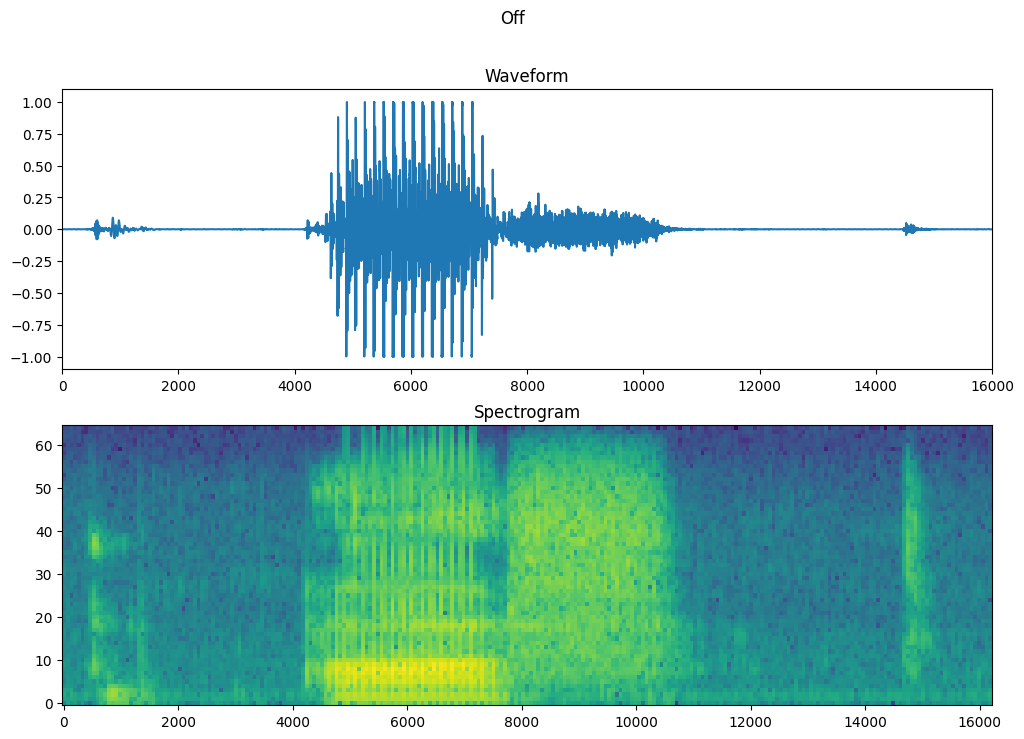

In [17]:
indx = random.randint(0, sample_audio.shape[0]-1)
label = label_names[sample_label[indx]]
waveform = sample_audio[indx]
spectrogram = get_spectrogram(waveform)
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [18]:
print('Spectrogram shape:', spectrogram.shape)

Spectrogram shape: (249, 65, 1)


In [19]:
def make_spectrogram_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

Convert into TensorFlow equivalent dataset

In [20]:
train_spectrogram_ds = make_spectrogram_ds(train_ds)
val_spectrogram_ds = make_spectrogram_ds(val_ds)
test_spectrogram_ds = make_spectrogram_ds(test_ds)

In [21]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Define the CNN model

In [24]:
from tensorflow.python.util.nest import flatten
from tensorflow.python.ops.gen_nn_ops import Conv2D
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  input_shape = example_spectrograms.shape[1:]
 
num_classes = 4


model = models.Sequential()
model.add(layers.Conv2D(8, (8, 8), strides=(2, 2), padding='SAME', activation='relu', input_shape=input_shape))  
model.add(layers.Flatten())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes, activation = 'softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 125, 33, 8)        520       
                                                                 
 flatten_2 (Flatten)         (None, 33000)             0         
                                                                 
 dropout_2 (Dropout)         (None, 33000)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132004    
                                                                 
Total params: 132,524
Trainable params: 132,524
Non-trainable params: 0
_________________________________________________________________


Train the model

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

model.fit(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=100)  

Epoch 1/100
150/150 [==============================] - 13s 19ms/step - loss: 0.8125 - accuracy: 0.7145 - val_loss: 0.5985 - val_accuracy: 0.7927
Epoch 2/100
150/150 [==============================] - 1s 6ms/step - loss: 0.5243 - accuracy: 0.8137 - val_loss: 0.5240 - val_accuracy: 0.8199
Epoch 3/100
150/150 [==============================] - 1s 5ms/step - loss: 0.4331 - accuracy: 0.8429 - val_loss: 0.5306 - val_accuracy: 0.8224
Epoch 4/100
150/150 [==============================] - 1s 5ms/step - loss: 0.3695 - accuracy: 0.8701 - val_loss: 0.4663 - val_accuracy: 0.8326
Epoch 5/100
150/150 [==============================] - 1s 5ms/step - loss: 0.3222 - accuracy: 0.8851 - val_loss: 0.5248 - val_accuracy: 0.8284
Epoch 6/100
150/150 [==============================] - 1s 7ms/step - loss: 0.2850 - accuracy: 0.9000 - val_loss: 0.4789 - val_accuracy: 0.8411
Epoch 7/100
150/150 [==============================] - 1s 6ms/step - loss: 0.2483 - accuracy: 0.9124 - val_loss: 0.5329 - val_accuracy: 0.83

Evaluate on test set

In [26]:
model.evaluate(test_spectrogram_ds)
model.save('model.h5')

19/19 [==============================] - 2s 109ms/step - loss: 1.9535 - accuracy: 0.8627


Convert into equivalent TfLite model

In [27]:
model = tf.keras.models.load_model('model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_quant_model)
tflite_models_dir = pathlib.Path('/content/tflite_models/')
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_quant_model)    

136320

Test the TFLite model

In [28]:
tflite_model_file = 'tflite_models/model.tflite'
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()
input_info = interpreter.get_input_details()[0]
input_index = input_info['index']
scale, offset = input_info['quantization']

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

total_count = 0.0
accurate_count = 0.0

for x, y_true in test_spectrogram_ds:
  input_shape = x.shape[1:]

  for count in range(x.shape[0]):
    temp = x[count,:]
    temp = tf.reshape(temp,(1, temp.shape[0], temp.shape[1], temp.shape[2]))

    interpreter.set_tensor(input_index, temp)
    interpreter.invoke()
    prediction = interpreter.get_tensor(output_index)[0]
    prediction = np.argmax(prediction)

    if prediction == y_true[count].numpy():
      accurate_count += 1
  
    total_count += 1
    
accuracy = accurate_count/total_count
print('Accuracy : ', accuracy)  

Accuracy :  0.8552631578947368


In this section, we create a representitive dataset comprising on, off and other keywords that will go to Edge Impulse. The silent data will be recorded at Edge Impulse 

In [29]:
os.mkdir('data/dataset')
os.mkdir('data/dataset/on')
os.mkdir('data/dataset/off')
os.mkdir('data/dataset/silent')
os.mkdir('data/dataset/others')

In [30]:
target_labels = ["on","off","others", "silent"]
sample_per_label = 600
for labels in target_labels:
  path = 'data/mydataset/'+labels

  f = os.listdir(path)
  num_files = len(f)
  file_indx = np.arange(num_files)
  random.shuffle(file_indx)

  for i in range(sample_per_label):
    indx = file_indx[i]
    file_name = f[indx]
    source = path + '/' + file_name
    destination = 'data/dataset/'+labels+'/' + file_name
    # copy only files
    if os.path.isfile(source):
        shutil.copy(source, destination)

compress the data into zip format, you need to download it 

In [31]:
!zip -r dataset.zip data/dataset/

  adding: data/dataset/ (stored 0%)
  adding: data/dataset/on/ (stored 0%)
  adding: data/dataset/on/1e9e6bdd_nohash_4.wav (deflated 20%)
  adding: data/dataset/on/3291330e_nohash_0.wav (deflated 21%)
  adding: data/dataset/on/2a89ad5c_nohash_1.wav (deflated 29%)
  adding: data/dataset/on/e71a9381_nohash_0.wav (deflated 18%)
  adding: data/dataset/on/459345ea_nohash_0.wav (deflated 33%)
  adding: data/dataset/on/44f68a83_nohash_2.wav (deflated 30%)
  adding: data/dataset/on/f953e1af_nohash_0.wav (deflated 46%)
  adding: data/dataset/on/195c120a_nohash_2.wav (deflated 41%)
  adding: data/dataset/on/96a48d28_nohash_0.wav (deflated 43%)
  adding: data/dataset/on/106a6183_nohash_0.wav (deflated 15%)
  adding: data/dataset/on/15c563d7_nohash_2.wav (deflated 19%)
  adding: data/dataset/on/4c6167ca_nohash_2.wav (deflated 31%)
  adding: data/dataset/on/c2dccf38_nohash_0.wav (deflated 16%)
  adding: data/dataset/on/57152045_nohash_0.wav (deflated 24%)
  adding: data/dataset/on/28e47b1a_nohash_3